# Template for evaluating several ML classification models

## Import basic Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dataset = pd.read_csv('Data_for_UCI_named.csv')
X = dataset.iloc[:, :-2].values
y = dataset.iloc[:, -1].values

In [3]:
print(y)

['unstable' 'stable' 'unstable' ... 'stable' 'unstable' 'unstable']


## Data Preprocessing

### Impute missing data

In [4]:
print(f"Missing data points: {dataset.isnull().sum().sum()}")

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X)
X = imputer.transform(X)

Missing data points: 0


### Encoding categorical data

**Label encoding** is used for binary target labels.

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
print(y)

[1 0 1 ... 0 1 1]


**One-Hot encoding** is used for more than one category.

Different transformers can be applied to different columns. They are given as a list of tuples (name, transformer, columns), where *name* is a unique identifyer, *transformer* the kind of encoding, and *columns* a list of columns the encoder is applied to.

The result is that the categoric column, containing C categories, is replaced by C new columns, of which for each sample only one contains the value 1 and all others the value 0 (One-Hot vector).

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

### Splitting the dataset into training and test data

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

### Feature scaling

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Principle Component Analysis (PCA)

PCA is used to reduce the dimentionality of the dataset. It minimizes the correlation between the features by performing a coordinate transformation onto the principle components (Eigenvectors). The user can then reduce the dataset to the principle components that contribute most to the variability of the data.

Following the PCA is performed with the maximum of target dimensions. The contribution of the dimensions to the variability of the dataset is then plotted in a Scree plot (histogram of the percetages of the contribution). From this it is easy to see how many dimension are needed to explain the dataset sufficiently (often 60 % is used).

In [9]:
from sklearn.decomposition import PCA
pca = PCA()#n_components = min(X_train.shape))
pca.fit(X_train)

PCA()

[1.68446645e-01 8.70710715e-02 8.67586137e-02 8.61793435e-02
 8.41591294e-02 8.41115634e-02 8.27319486e-02 8.12700175e-02
 8.04378276e-02 7.97623905e-02 7.90714497e-02 4.54835222e-31]


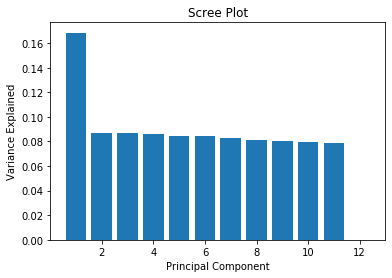

0.6794583146563521


In [10]:
# Plotting the Scree plot
print(pca.explained_variance_ratio_)
PC_values = np.arange(pca.n_components_) + 1
plt.bar(PC_values, pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()
print(pca.explained_variance_ratio_[:7].sum())

In [ ]:
# Get the number of principal components needed to have a sum of variances above a certain limit.
LIMIT = 0.6
sum_of_variance = 0
i = 0
while sum_of_variance < LIMIT:
    sum_of_variance += pca.explained_variance_ratio_[i]
    i += 1
number_of_principal_components = i
print(f"Sum of variances = {sum_of_variance} at {number_of_principal_components} principle components.")

In [ ]:
# Run the PCA with the chosen number of principle components.
pca = PCA(n_components = number_of_principal_components)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(X_train.shape)

In cases the data is not linearly separatable, KernelPCA may help.

In [11]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = min(X_train.shape), kernel = 'rbf')
kpca.fit(X_train)

KernelPCA(kernel='rbf', n_components=12)

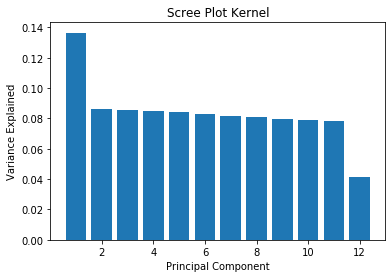

In [14]:
# Plotting the Scree plot
PC_values = np.arange(kpca.n_features_in_) + 1
plt.bar(PC_values, kpca.eigenvalues_ / kpca.eigenvalues_.sum())
plt.title('Scree Plot Kernel')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [15]:
# Get the number of principal components needed to have a sum of variances above a certain limit.
LIMIT = 0.6
sum_of_variance = 0
i = 0
while sum_of_variance < LIMIT:
    sum_of_variance += kpca.eigenvalues_[i] / kpca.eigenvalues_.sum()
    i += 1
number_of_principal_components = i
print(f"Sum of variances = {sum_of_variance} at {number_of_principal_components} principle components.")

Sum of variances = 0.6411601938133991 at 7 principle components.


### Linear Discriminant Analysis (LDA)

# Comparing the ML classifiers

## Import the classifier classes

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

## Model and parameter definitions

In [ ]:
names = [
    "Logistic Regression",
    "K-nearest Neighbors",
    "SVM",
    #"Linear SVM",
    #"RBF SVM",
    "Naive Bayes",
    "Decision Tree",
    "Random Forest",
]

classifiers = [
    LogisticRegression(random_state=0),
    KNeighborsClassifier(metric = 'minkowski', p = 2),
    SVC(random_state=0),
    #SVC(kernel = 'linear', random_state = 0),
    #SVC(kernel = 'rbf', random_state = 0),
    GaussianNB(),
    DecisionTreeClassifier(random_state = 0),
    RandomForestClassifier(random_state = 0)am
]

parameters = [
    [
        {'C': [0.25, 0.5, 0.75, 1, 10]}
    ],
    [
        {'n_neighbors': [2, 3, 4, 5, 10, 20, 100], 'weights': ['uniform', 'distance']}
    ],
    [
        {'C': [0.25, 0.5, 0.75, 1, 10], 'kernel': ['linear']},
        #{'C': [0.25, 0.5, 0.75, 1, 10], 'kernel': ['poly'], 'degree': [2, 3, 4, 5]},
        #{'C': [0.25, 0.5, 0.75, 1, 10], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}         
    ],
    [
        {}
    ],
    [
        {'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [2, 3, 4, 5, 8, 12, 20]}
    ],
    [
        {'n_estimators': [5, 10, 20, 100, 1000], 'max_depth': [2, 3, 4, 5, 8, 12, 20, 100], 'criterion': ['gini', 'entropy', 'log_loss']}
    ]    
]

## Model Comparison at standard settings

In [ ]:
print(f"Classifier {:20} Accuracy {:5}")
for name, classifier in zip(names, classifiers):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(f"Classifier: {name:20},  accuracy: {accuracy_score(y_test, y_pred) * 100:5.2f}%")

## Hyperparameter tuning using Grid Search including k-fold Cross Validation

In [ ]:
print(f"Classifier {:20} Best Accuracy {:20.2f} Parameter combination")
for name, classifier, params in zip(names, classifiers, parameters):
    grid_search = GridSearchCV(estimator = classifier,
                           param_grid = params,
                           scoring = 'accuracy',
                           cv = 10,  # Number of cross validations
                           n_jobs = -1)  # number of CPU cores used. -1 indicates to use all cores.
    grid_search.fit(X_train, y_train)
    print(f"{name:20} {grid_search.best_score_ * 100: 5.2f} {grid_search.best_params_}")